## Final Project Part 4

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import requests

pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

%matplotlib inline

import time
from sklearn import linear_model, metrics, model_selection, feature_selection 

def get_linear_model_metrics(X, y, algo):
    # get the pvalue of X given y. Ignore f-stat for now.
    pvals = feature_selection.f_regression(X, y)[1]
    # start with an empty linear regression object
    # .fit() runs the linear regression function on X and y
    algo.fit(X,y)
    residuals = (y-algo.predict(X)).values

    # print the necessary values
    print 'P Values:', pvals
    print 'Coefficients:', algo.coef_
    print 'y-intercept:', algo.intercept_
    print 'R-Squared:', algo.score(X,y)
    plt.figure()
    plt.hist(residuals)
    # keep the model
    return algo

In [2]:
#Import df_tiny
df_tiny = pd.read_csv("LIHTC_Properties_wGeocode_Census.csv",low_memory=False)

### Enhance the data even further by comparing each census tract to the state medians
#### Yes, it's a little more data cleanup but it makes the analysis more compelling

In [3]:
#import the state dataset (the same API as before was run on this)
df_states = pd.read_csv("States_with_Income.csv",low_memory=False)
df_states['PROJ_ST'] = df_states['Abbrev']
df_states['Code'] = df_states['Code'].astype(str).str.strip().astype(int)
df_states['StateCode'] = df_states.Code.map("{:02}".format)
print len(df_states)
df_states.head(10)

51


,Unnamed: 0,Code,State Code,State,Abbrev,ID_Code,MHI_2010,MHI_2011,MHI_2012,MHI_2013,MHI_2014,MHI_2015,10_14_Growth,PercentGrowth,PROJ_ST,StateCode
0,0,1,1,Alabama,AL,1,21746,22217,22318,22394,22626,22890,880,0.040467,AL,01
1,1,2,2,Alaska,AK,2,29509,30604,31005,30947,31441,31455,1932,0.065472,AK,02
2,2,4,4,Arizona,AZ,4,26412,26611,26388,26073,26110,26156,-302,-0.011434,AZ,04
3,3,5,5,Arkansas,AR,5,20881,21356,21604,21771,22067,22205,1186,0.056798,AR,05
4,4,6,6,California,CA,6,27207,27355,27129,26893,26932,27035,-275,-0.010108,CA,06
5,5,8,8,Colorado,CO,8,29365,29921,30084,30141,30393,30752,1028,0.035008,CO,08
6,6,9,9,Connecticut,CT,9,32258,32910,32842,32651,33009,33226,751,0.023281,CT,09
7,7,10,10,Delaware,DE,10,29205,29975,29752,29699,30062,30329,857,0.029344,DE,10
8,8,11,11,District of Columbia,DC,11,35264,37217,38230,39158,40381,40884,5117,0.145105,DC,11
9,9,12,12,Florida,FL,12,24812,25014,24683,24344,24501,24654,-311,-0.012534,FL,12


### Refine the data set and create dummy variables, as well as other calculations
#### We're predicitng "Percent Growth" which is the change from 2010 to 2014 (the longest time series available from the Census)

In [4]:
df_tiny =  df_tiny[(df_tiny.YR_PIS == 2006)|(df_tiny.YR_PIS == 2007)|(df_tiny.YR_PIS == 2008)|(df_tiny.YR_PIS == 2009)|(df_tiny.YR_PIS == 2010) | (df_tiny.YR_PIS == 2011)|(df_tiny.YR_PIS == 2012)|(df_tiny.YR_PIS == 2013)|(df_tiny.YR_PIS == 2014)|(df_tiny.YR_PIS == 2015)]
#df_tiny =  df_tiny[(df_tiny.YR_PIS == 2006)]
df_tiny = df_tiny[np.isfinite(df_tiny['MHI_2014'])]
df_tiny = df_tiny[np.isfinite(df_tiny['MHI_2010'])]
df_tiny = df_tiny[np.isfinite(df_tiny['HH_2010'])]
df_tiny = df_tiny[np.isfinite(df_tiny['N_UNITS'])]
df_tiny = df_tiny[np.isfinite(df_tiny['LI_UNITS'])]

#creating income growth 
df_tiny['10_14_Growth'] = df_tiny['MHI_2014'].astype(int) - df_tiny['MHI_2010'].astype(int)
df_tiny['PercentGrowth'] = (df_tiny['MHI_2014'].astype(int) - df_tiny['MHI_2010'].astype(int)) / df_tiny['MHI_2010'].astype(int)
print len(df_tiny)

df_tiny['Code'] = df_tiny['STATE2KX'].astype(str).str.strip().astype(int)
df_tiny['StateCode'] = df_tiny.Code.map("{:02}".format)


df_tiny['N_UNITS'] = df_tiny['N_UNITS'].astype(float)
df_tiny['TRGT_FAM'] = df_tiny['TRGT_FAM'].astype(int)

print "unique values in  target family " + str(df_tiny.TRGT_FAM.unique())
print "unique values in type" + str(df_tiny.TYPE.unique())

print 'len before merge: ' + str(len(df_tiny))
#append state household data to each row (so we can see how this census tract compared to the entire state)
df_tiny.head(3)
df_tiny = df_tiny.merge(df_states, on='StateCode',indicator=True)

print 'len after merge: ' + str(len(df_tiny))

df_tiny['IncomeLevel'] = df_tiny['MHI_2010_x'] / df_tiny['MHI_2010_y']

#create qct, family, dummy
df_tiny= pd.get_dummies(df_tiny, prefix='TargetPop', columns=['TRGT_FAM'])
df_tiny= pd.get_dummies(df_tiny, prefix='ConsType', columns=['TYPE'])
df_tiny= pd.get_dummies(df_tiny, prefix='Metro', columns=['METRO'])
df_tiny= pd.get_dummies(df_tiny, prefix='DDA', columns=['DDA'])
df_tiny= pd.get_dummies(df_tiny, prefix='QCT', columns=['QCT'])

df_tiny.head(2)


10434
unique values in  target family [2 1 0]
unique values in type[1 3 2 0]
len before merge: 10434
len after merge: 10434


,Unnamed: 0_x,FID,OBJECTID,HUD_ID,PROJECT,PROJ_ADD,PROJ_CTY,PROJ_ST_x,PROJ_ZIP,STATE_ID,CONTACT,COMPANY,CO_ADD,CO_CTY,CO_ST,CO_ZIP,CO_TEL,ALLOCAMT,N_UNITS,LI_UNITS,N_0BR,N_1BR,N_2BR,N_3BR,N_4BR,INC_CEIL,LOW_CEIL,CEILUNIT,YR_PIS,YR_ALLOC,NON_PROF,BASIS,BOND,MFF_RA,MFF_RA_ID,FMHA_514,RDNUM_514,FMHA_515,RDNUM_515,FMHA_538,RDNUM_538,HOME,HOME_AMT,HOME_IDISI,TCAP,TCAP_AMT,TCAP_IDISI,CDBG,CDBG_AMT,CDBG_IDISI,FHA,FHA_NUM,HOPEVI,HPVI_AMT,TCEP,TCEP_AMT,RENTASSIST,TRGT_POP,TRGT_ELD,TRGT_DIS,TRGT_HML,TRGT_OTHER,TRGT_SPC,CREDIT,N_UNITSR,LI_UNITR,NONPROG,DATANOTE,METRO_TRAC,STATE2KX,CNTY_NM2KX,CNTY2KX,TRACT2KX,BG2KX,BLOCK2KX,CURCNTY_NM,CURCNTY,CURCOSUB,CURCOSUB_N,PLACE2KX,PLACE_NM2K,PLACE_CC2K,PLACE_INC2,MSA_NM,CBSA_NM,NECTA,NECTA_NM,MICRO,FCD_FIPS91,HLC,DPV,DPVRC,STD_ADDR,URB_OUT,STD_CITY,STD_ST,STD_ZIP5,STD_ZIP9,ZIP_CLASS,ZCTA2KX,DPBC,DPBC_CKSUM,STD_ZIP11,ADDR_TYPE,APT_NO,APT_TYPE,C1PGRC,C1PPRB,C1PDRC,C1PSRC,C1PARC,C1PRC9,MSGUSPS,LAT,LON,RC2KX,STM2KX,LVL2KX,UR,MSG2KX,COUNTY_LEV,PLACE_LEVE,TRACT_LEVE,BLKGRP_LEV,MSA,CBSA,MHI_2010_x,MHI_2011_x,MHI_2012_x,MHI_2013_x,MHI_2014_x,MHI_2015_x,HH_2010,10_14_Growth_x,PercentGrowth_x,Code_x,StateCode,Unnamed: 0_y,Code_y,State Code,State,Abbrev,ID_Code,MHI_2010_y,MHI_2011_y,MHI_2012_y,MHI_2013_y,MHI_2014_y,MHI_2015_y,10_14_Growth_y,PercentGrowth_y,PROJ_ST_y,_merge,IncomeLevel,TargetPop_0,TargetPop_1,TargetPop_2,ConsType_0,ConsType_1,ConsType_2,ConsType_3,Metro_0,Metro_1,DDA_0,DDA_1,DDA_2,DDA_3,DDA_4,QCT_0,QCT_1,QCT_2
0,0,0,5001,CAA2010235,ROSA PARKS VILLAS,2507 S BRONSON AVE,LOS ANGELES,CA,90018,CA-07-009,J DUPONT-WALKER,WEDC,1177 W ADAMS BLVD,LOS ANGELES,CA,90007-2397,213-747-1188,1008162.0,60.0,59,0,51,9,0,0,2,1,42,2010,2007,1,1,2,0,,2,0,2,,2,0,1,5005267,0,0,0,0,2,0,0,2,0,2,0,0,0,4,1,1,0,0,0,,2,60,59,0,,2,6,Los Angeles,37,218702,1,1004,Los Angeles,37,91750,Los Angeles,44000,Los Angeles city (part),C1,,"Los Angeles-Long Beach, CA PMSA","Los Angeles-Long Beach-Glendale, CA Metropolit...",99999,,0,0637,2118,D,,2507 S Bronson Ave,,Los Angeles,CA,90018,1973,,90018,99,4,90018197399,H,,,,0,,,N,,100% Overall probable correctness,34.033907,-118.332789,S,,R,U,** Street-Level Rooftop **,6037,0644000,6037218702,60372187021,4480,31084,15307.0,15854.0,16068.0,15307.0,17582.0,NaN,826.0,2275,0.148625,6,06,4,6,6,California,CA,6,27207,27355,27129,26893,26932,27035,-275,-0.010108,CA,both,0.562613,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,1
1,1,1,5002,CAA2011484,CUATRO VIENTOS,5331 HUNTINGTON DR N,LOS ANGELES,CA,90032,CA-09-205,JACQUELINE MONTERROSAS,EAST LA COMMUNITY CORP,530 S BOYLE AVE,LOS ANGELES,CA,90033-3817,323-269-4214,762545.0,24.0,24,0,6,10,7,2,2,1,24,2011,2009,1,1,2,2,,2,0,2,,2,0,2,0,0,0,0,0,2,0,0,2,0,2,0,1,585260,4,1,0,0,0,0,,2,24,24,0,,2,6,Los Angeles,37,201120,1,1007,Los Angeles,37,91750,Los Angeles,44000,Los Angeles city (part),C1,,"Los Angeles-Long Beach, CA PMSA","Los Angeles-Long Beach-Glendale, CA Metropolit...",99999,,0,0634,2118,D,,5331 Huntington Dr N,,Los Angeles,CA,90032,1871,,90032,99,1,90032187199,H,,,,0,,,N,,100% Overall probable correctness,34.091266,-118.164639,S,,R,U,** Street-Level Rooftop **,6037,0644000,6037201120,60372011201,4480,31084,20473.0,20343.0,18528.0,18129.0,18436.0,17846.0,1221.0,-2037,-0.099497,6,06,4,6,6,California,CA,6,27207,27355,27129,26893,26932,27035,-275,-0.010108,CA,both,0.752490,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1


count    10434.000000
mean         0.848622
std          0.335148
min          0.121152
25%          0.620171
50%          0.794941
75%          1.008118
max          4.653381
Name: IncomeLevel, dtype: float64

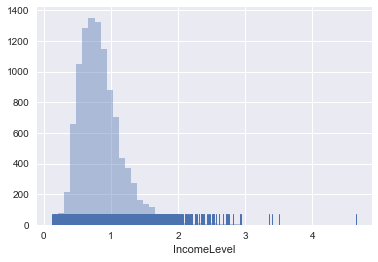

In [5]:
#create distribution of income percentages
sns.distplot(df_tiny['IncomeLevel'], kde=False, rug=True,bins=50)
df_tiny['IncomeLevel'].describe()

In [6]:
# Any census tract with income at or above its state median income can be considered "high income".

#I've noted it with the category "income threshold" below. This would put it in the 75th percentile and above for all Census Tracts
# with LIHTC projects
df_tiny['IncomeThresh'] = 0
df_tiny.loc[df_tiny.IncomeLevel > 1, 'IncomeThresh'] = 1


In [7]:
#remove outliers in teh data set
#50% growth rate is probably unrealistic and is a data in the ACS Median Income data
df_tiny = df_tiny[(df_tiny.PercentGrowth_x < .5)]
#df_tiny = df_tiny[(df_tiny.N_UNITS < 300)]
#df_tiny = df_tiny[(df_tiny.TYPE == 1)]
#df_tiny = df_tiny[(df_tiny.TYPE == 1)]
#df_tiny = df_tiny[(df_tiny.PROJ_ST == 'CA')]


### Aggregate census tracts with multiple properties on them to sum the total numbers of units. Increases the effectiveness of the model

In [8]:
#group by census tract. use this to sum the total number of units in a single census tract (so we don't repeat)
df_group = df_tiny.groupby('TRACT_LEVE').agg(sum)
df_group = df_group.reset_index()
df_group = df_group[['TRACT_LEVE','N_UNITS','LI_UNITS']]
print len(df_group)

df_group.head(10)
print len(df_tiny)

#now do a merge based on df_tiny
df = pd.merge(df_tiny, df_group, on='TRACT_LEVE', how='inner')

print len(df)
df.head(5)

7489
10265
10265


,Unnamed: 0_x,FID,OBJECTID,HUD_ID,PROJECT,PROJ_ADD,PROJ_CTY,PROJ_ST_x,PROJ_ZIP,STATE_ID,CONTACT,COMPANY,CO_ADD,CO_CTY,CO_ST,CO_ZIP,CO_TEL,ALLOCAMT,N_UNITS_x,LI_UNITS_x,N_0BR,N_1BR,N_2BR,N_3BR,N_4BR,INC_CEIL,LOW_CEIL,CEILUNIT,YR_PIS,YR_ALLOC,NON_PROF,BASIS,BOND,MFF_RA,MFF_RA_ID,FMHA_514,RDNUM_514,FMHA_515,RDNUM_515,FMHA_538,RDNUM_538,HOME,HOME_AMT,HOME_IDISI,TCAP,TCAP_AMT,TCAP_IDISI,CDBG,CDBG_AMT,CDBG_IDISI,FHA,FHA_NUM,HOPEVI,HPVI_AMT,TCEP,TCEP_AMT,RENTASSIST,TRGT_POP,TRGT_ELD,TRGT_DIS,TRGT_HML,TRGT_OTHER,TRGT_SPC,CREDIT,N_UNITSR,LI_UNITR,NONPROG,DATANOTE,METRO_TRAC,STATE2KX,CNTY_NM2KX,CNTY2KX,TRACT2KX,BG2KX,BLOCK2KX,CURCNTY_NM,CURCNTY,CURCOSUB,CURCOSUB_N,PLACE2KX,PLACE_NM2K,PLACE_CC2K,PLACE_INC2,MSA_NM,CBSA_NM,NECTA,NECTA_NM,MICRO,FCD_FIPS91,HLC,DPV,DPVRC,STD_ADDR,URB_OUT,STD_CITY,STD_ST,STD_ZIP5,STD_ZIP9,ZIP_CLASS,ZCTA2KX,DPBC,DPBC_CKSUM,STD_ZIP11,ADDR_TYPE,APT_NO,APT_TYPE,C1PGRC,C1PPRB,C1PDRC,C1PSRC,C1PARC,C1PRC9,MSGUSPS,LAT,LON,RC2KX,STM2KX,LVL2KX,UR,MSG2KX,COUNTY_LEV,PLACE_LEVE,TRACT_LEVE,BLKGRP_LEV,MSA,CBSA,MHI_2010_x,MHI_2011_x,MHI_2012_x,MHI_2013_x,MHI_2014_x,MHI_2015_x,HH_2010,10_14_Growth_x,PercentGrowth_x,Code_x,StateCode,Unnamed: 0_y,Code_y,State Code,State,Abbrev,ID_Code,MHI_2010_y,MHI_2011_y,MHI_2012_y,MHI_2013_y,MHI_2014_y,MHI_2015_y,10_14_Growth_y,PercentGrowth_y,PROJ_ST_y,_merge,IncomeLevel,TargetPop_0,TargetPop_1,TargetPop_2,ConsType_0,ConsType_1,ConsType_2,ConsType_3,Metro_0,Metro_1,DDA_0,DDA_1,DDA_2,DDA_3,DDA_4,QCT_0,QCT_1,QCT_2,IncomeThresh,N_UNITS_y,LI_UNITS_y
0,0,0,5001,CAA2010235,ROSA PARKS VILLAS,2507 S BRONSON AVE,LOS ANGELES,CA,90018,CA-07-009,J DUPONT-WALKER,WEDC,1177 W ADAMS BLVD,LOS ANGELES,CA,90007-2397,213-747-1188,1008162.0,60.0,59,0,51,9,0,0,2,1,42,2010,2007,1,1,2,0,,2,0,2,,2,0,1,5005267,0,0,0,0,2,0,0,2,0,2,0,0,0,4,1,1,0,0,0,,2,60,59,0,,2,6,Los Angeles,37,218702,1,1004,Los Angeles,37,91750,Los Angeles,44000,Los Angeles city (part),C1,,"Los Angeles-Long Beach, CA PMSA","Los Angeles-Long Beach-Glendale, CA Metropolit...",99999,,0,0637,2118,D,,2507 S Bronson Ave,,Los Angeles,CA,90018,1973,,90018,99,4,90018197399,H,,,,0,,,N,,100% Overall probable correctness,34.033907,-118.332789,S,,R,U,** Street-Level Rooftop **,6037,0644000,6037218702,60372187021,4480,31084,15307.0,15854.0,16068.0,15307.0,17582.0,NaN,826.0,2275,0.148625,6,06,4,6,6,California,CA,6,27207,27355,27129,26893,26932,27035,-275,-0.010108,CA,both,0.562613,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,60.0,59
1,1,1,5002,CAA2011484,CUATRO VIENTOS,5331 HUNTINGTON DR N,LOS ANGELES,CA,90032,CA-09-205,JACQUELINE MONTERROSAS,EAST LA COMMUNITY CORP,530 S BOYLE AVE,LOS ANGELES,CA,90033-3817,323-269-4214,762545.0,24.0,24,0,6,10,7,2,2,1,24,2011,2009,1,1,2,2,,2,0,2,,2,0,2,0,0,0,0,0,2,0,0,2,0,2,0,1,585260,4,1,0,0,0,0,,2,24,24,0,,2,6,Los Angeles,37,201120,1,1007,Los Angeles,37,91750,Los Angeles,44000,Los Angeles city (part),C1,,"Los Angeles-Long Beach, CA PMSA","Los Angeles-Long Beach-Glendale, CA Metropolit...",99999,,0,0634,2118,D,,5331 Huntington Dr N,,Los Angeles,CA,90032,1871,,90032,99,1,90032187199,H,,,,0,,,N,,100% Overall probable correctness,34.091266,-118.164639,S,,R,U,** Street-Level Rooftop **,6037,0644000,6037201120,60372011201,4480,31084,20473.0,20343.0,18528.0,18129.0,18436.0,17846.0,1221.0,-2037,-0.099497,6,06,4,6,6,California,CA,6,27207,27355,27129,26893,26932,27035,-275,-0.010108,CA,both,0.752490,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,24.0,24
2,2,2,5003,CAA2011485,VILLAGE AT BROAD STREET,2260 EMILY ST,SAN LUIS OBISPO,CA,93401,CA-09-124,JONATHAN EMAMI,ROEM BROAD STREET FAMILY LLC,1650 LAFAYETTE ST,SANTA CLARA,CA,95050-3915,408-984-5600,1493365.0,42.0,41,0,2,16,24,0,2,1,31,2011,2009,2,1,2,0,,2,0,2,,2,0,2,0,0,0,0,0,2,0,0,2,0,2,0,1,746683,4,1,2,2,2,2,,2,42,41,0,Previously listed as CAA2011633.,2,6,San Luis Obispo,79,11102,4,4025,San Luis Obispo,79,92860,San Luis Obispo,68154,San Luis Obispo city,C1,,"San Luis Obispo-Atascadero-Paso Robles, CA MSA","San Luis Obispo-Paso Robles-Arroyo Grande, CA ...",99999,,0,0624,3288,N,,2260 Emily St,,San Luis Obispo,C

### Overall model
#### For the entire country

<bound method LinearRegression.get_params of LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)>
[   0.9696541    -1.69623596   56.13440601 -189.21028697 -107.8932814 ]
R-squared 0.865114941194
MSE 12600676.6787
~~~~Linear Model Metrics~~~~~
P Values: [ 0.          0.40916979  0.05365917  0.20943458  0.        ]
Coefficients: [   0.9696541    -1.69623596   56.13440601 -189.21028697 -107.8932814 ]
y-intercept: 1372.6937649
R-Squared: 0.865114941194
[ 49685.77532056]


C:\ProgramData\Anaconda2\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


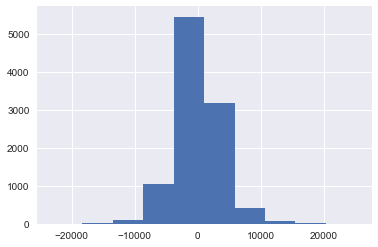

In [9]:
X = df[['MHI_2010_x','LI_UNITS_x','TargetPop_1','DDA_1','IncomeThresh']]

#square polynomial
#log transform the number of units

y = df['MHI_2014_x']

#lm = linear_model.SGDRegressor(random_state=4)
lm = linear_model.LinearRegression()
lm.fit(X, y)
print lm.get_params
print lm.coef_
print 'R-squared', lm.score(X,y)
print 'MSE', metrics.mean_squared_error(y, lm.predict(X))


print "~~~~Linear Model Metrics~~~~~"
lm = get_linear_model_metrics(X, y, lm)
# prediction at 0?


print lm.predict(np.array([50000,100,0,0,0])) 

In [15]:
lm.predict(np.array([50000,400,0,0,1]))

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([ 49069.01125226])

In [16]:
#lasso and ridge wont solve high bian, will only help for variance

lm = linear_model.Lasso().fit(X, y)
print "~~~ Lasso ~~~"
print 'Lasso MSE: ', metrics.mean_squared_error(y, lm.predict(X))
print 'Lasso R2:', lm.score(X, y)


lm = linear_model.Ridge().fit(X, y)
print "~~~ Ridge ~~~"
print 'Ridge MSE: ', metrics.mean_squared_error(y, lm.predict(X))
print 'Ridge R2:', lm.score(X, y)


~~~ Lasso ~~~
Lasso MSE:  12600700.8353
Lasso R2: 0.865114682607
~~~ Ridge ~~~
Ridge MSE:  12600676.6829
Ridge R2: 0.865114941149


In [ ]:
resids = y - lm.predict(X)
sns.distplot(resids)

#### The model will be looping through all the states and training  for each state.

['CA' 'DE' 'CO' 'DC' 'FL' 'CT' 'AR' 'AZ' 'GA' 'HI' 'IA' 'ID' 'IL' 'AK' 'AL'
 'KY' 'MA' 'LA' 'MD' 'IN' 'ME' 'KS' 'MI' 'MN' 'MT' 'NC' 'MO' 'MS' 'NE' 'NJ'
 'NH' 'ND' 'NV' 'NY' 'NM' 'OH' 'OR' 'PA' 'OK' 'RI' 'SC' 'SD' 'TN' 'WV' 'WI'
 'WY' 'TX' 'VA' 'VT' 'UT' 'WA']
51
~~~~~~RUNNING FOR CA ~~~~~~
<bound method LinearRegression.get_params of LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)>
[  0.97936595   0.12848322 -71.81887219 -35.62898902 -51.97154011]
R-squared 0.887522368463
MSE 13833490.6432
~~~~~~RUNNING FOR DE ~~~~~~
<bound method LinearRegression.get_params of LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)>
[  8.89847211e-01  -1.00956504e+01   4.43033470e+03   0.00000000e+00
   3.86215430e+03]
R-squared 0.795918560933
MSE 11760500.5878
~~~~~~RUNNING FOR CO ~~~~~~
<bound method LinearRegression.get_params of LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)>
[  9.43313400e-01  -1.12447685e+00   1.1968

<bound method LinearRegression.get_params of LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)>
[  8.69655249e-01   1.52277576e+01  -4.48813119e+03  -7.45611801e+02
   3.31487771e+03]
R-squared 0.881880943139
MSE 18005878.7563
~~~~~~RUNNING FOR NH ~~~~~~
<bound method LinearRegression.get_params of LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)>
[  8.18626043e-01  -3.91188033e+01   1.04832425e+03   0.00000000e+00
   2.98891777e+01]
R-squared 0.688808495524
MSE 15125996.3077
~~~~~~RUNNING FOR ND ~~~~~~
<bound method LinearRegression.get_params of LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)>
[  5.55828229e-01   4.19925107e+01   1.29989590e+03   0.00000000e+00
   5.61481577e+03]
R-squared 0.797217686005
MSE 8903193.35945
~~~~~~RUNNING FOR NV ~~~~~~
<bound method LinearRegression.get_params of LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)>
[  8.96696792e-01  -1.70889168e

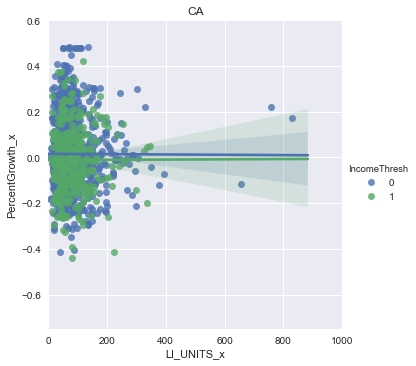

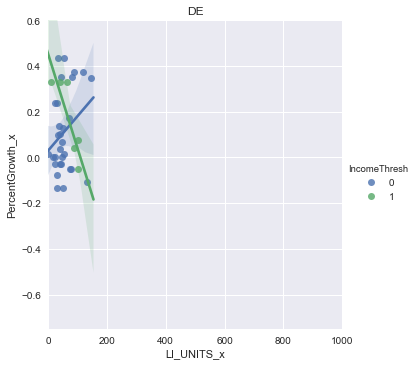

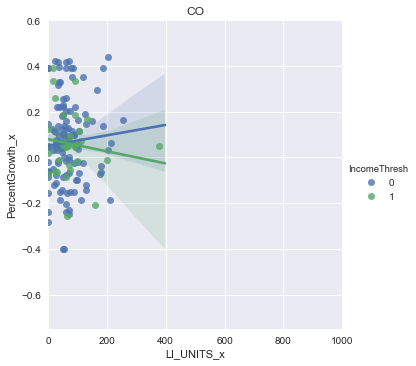

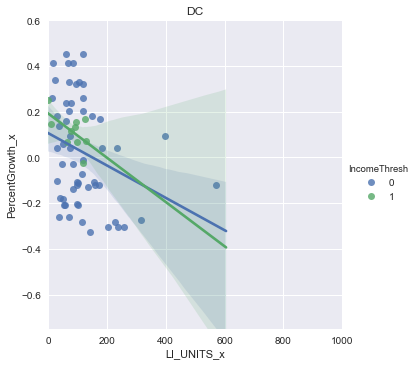

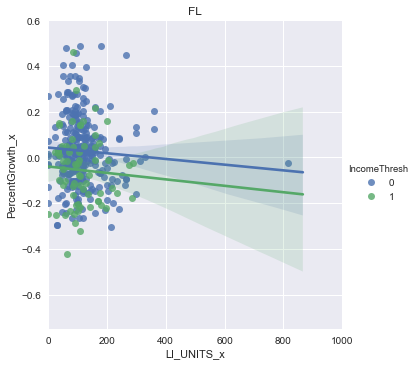

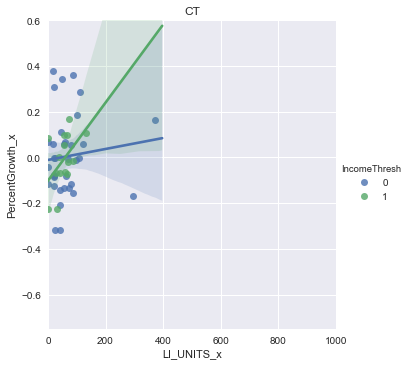

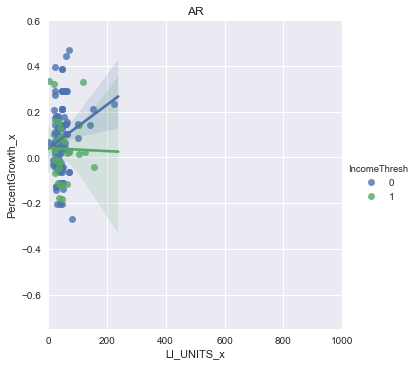

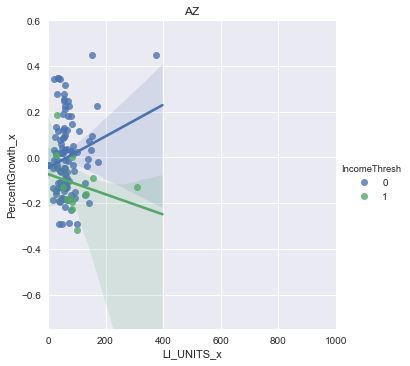

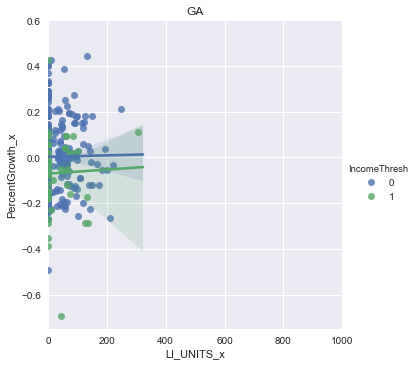

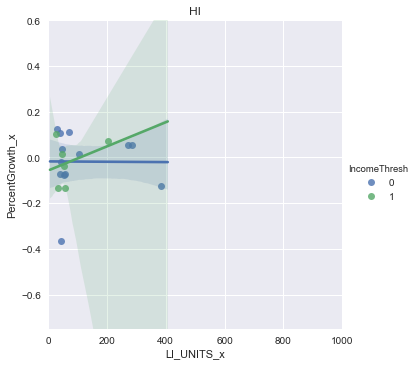

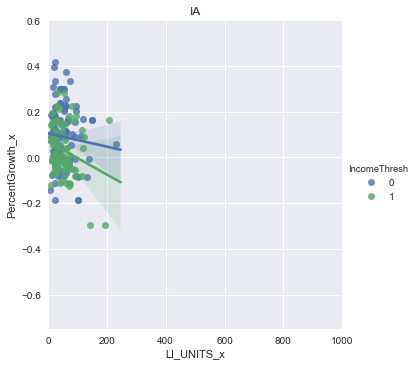

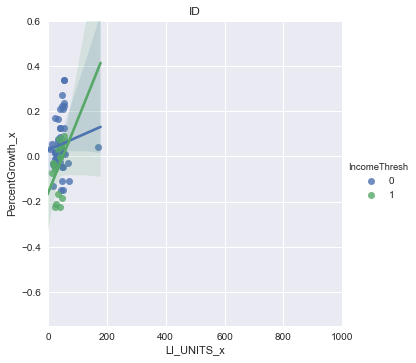

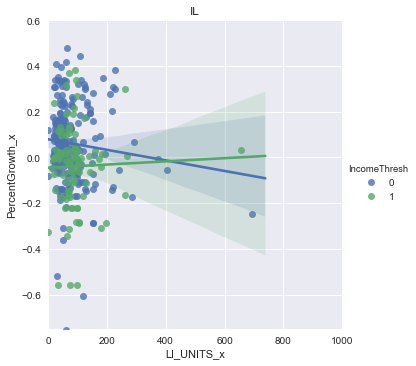

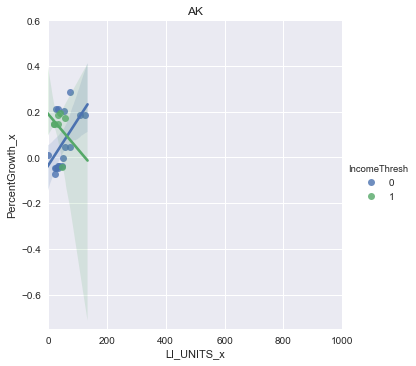

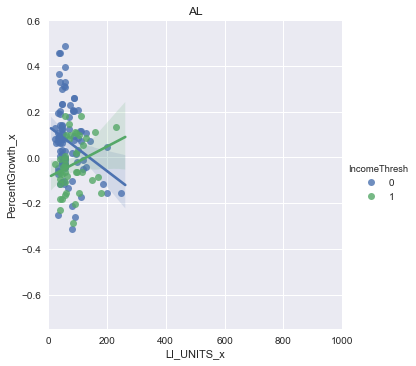

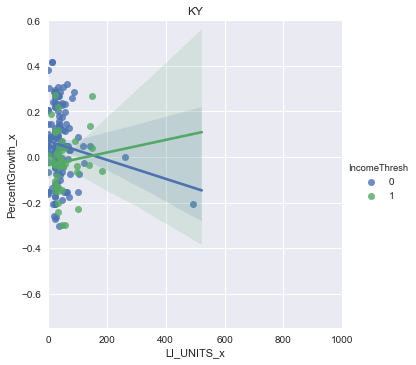

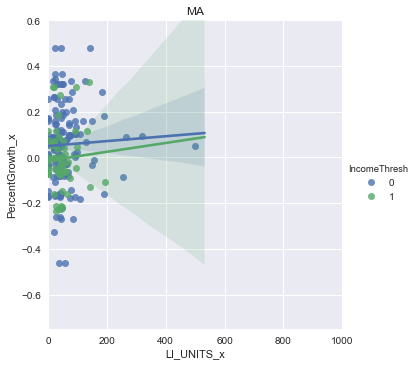

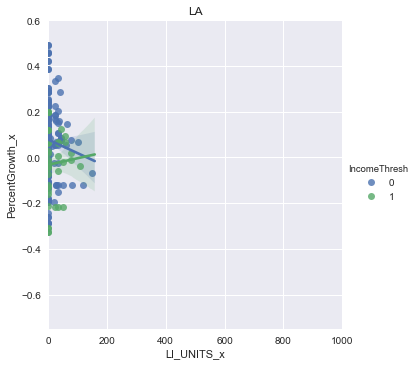

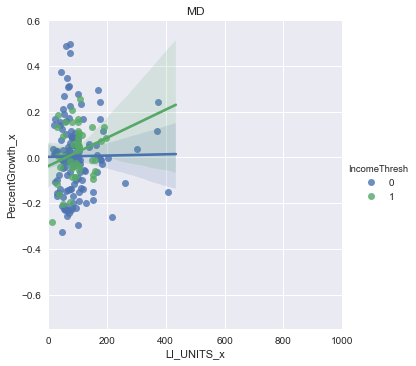

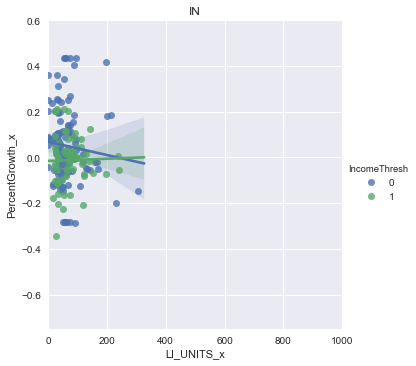

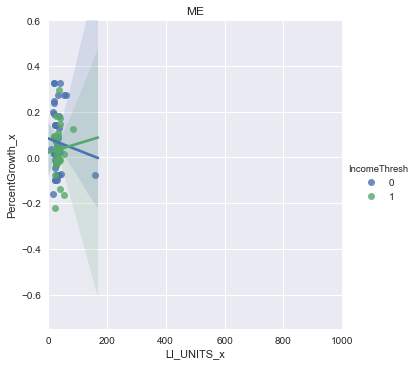

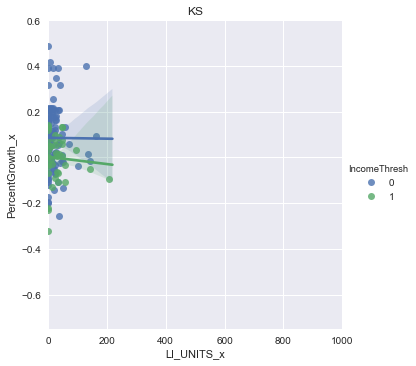

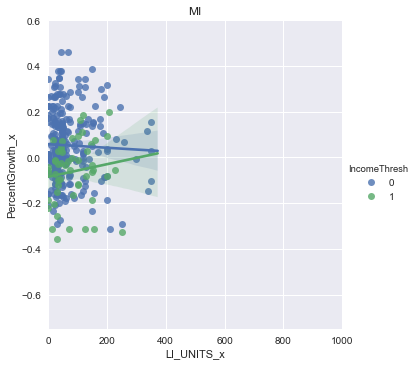

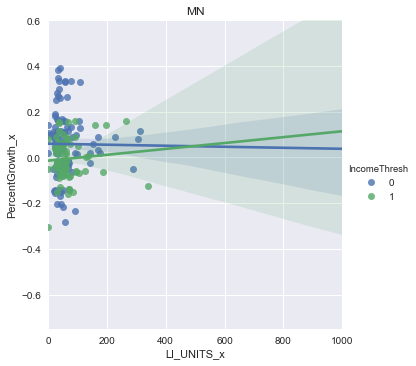

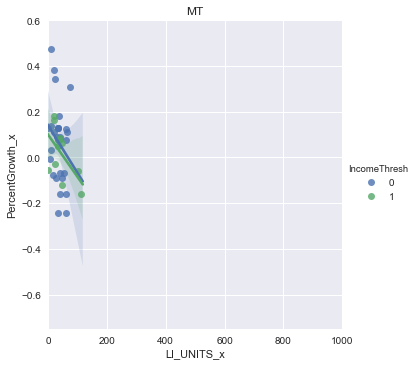

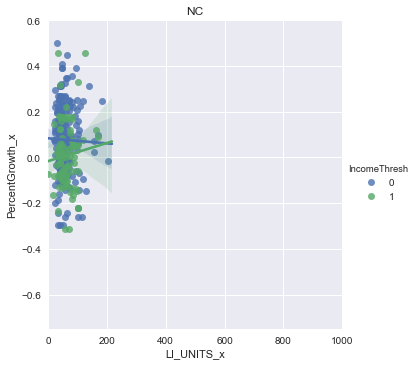

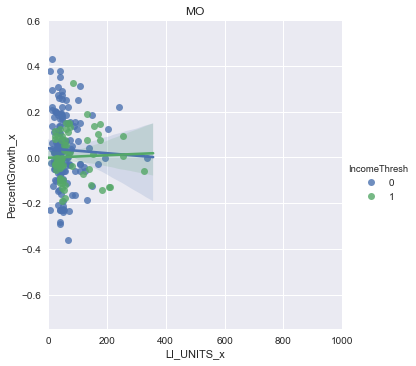

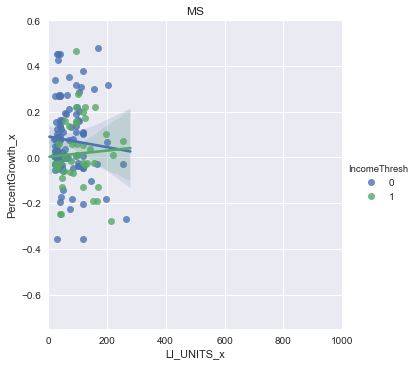

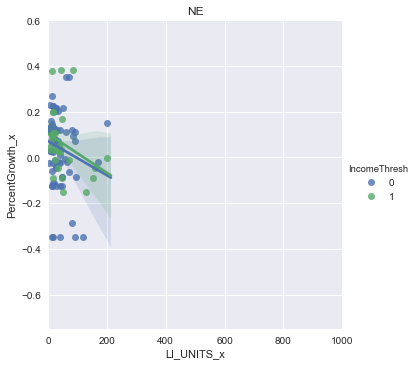

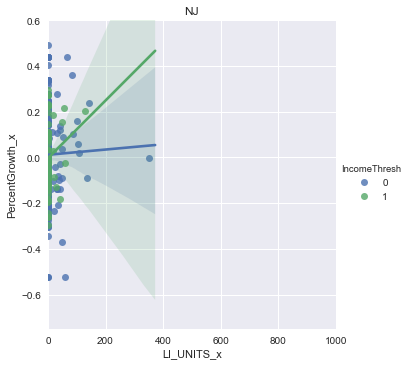

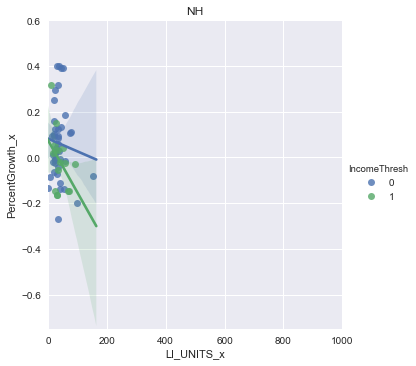

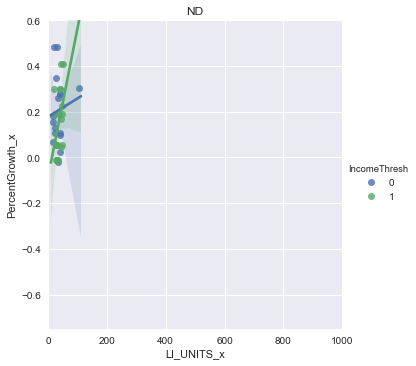

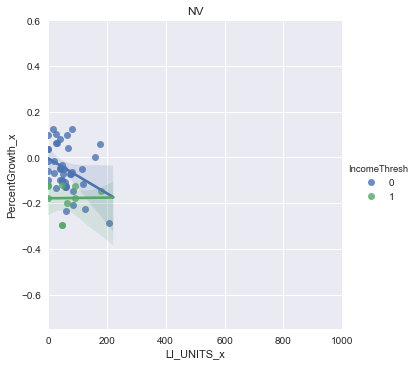

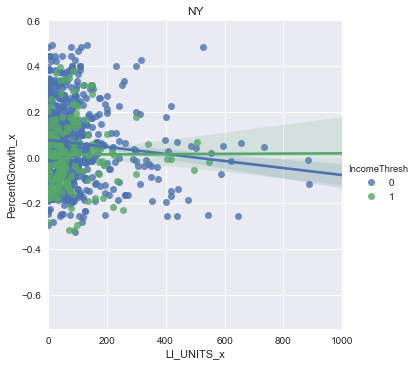

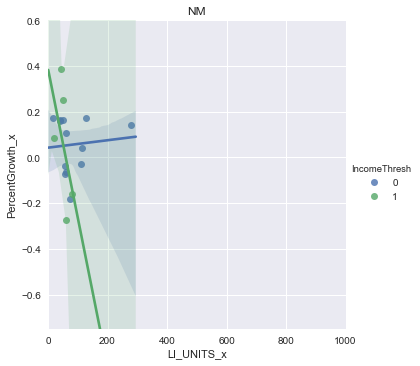

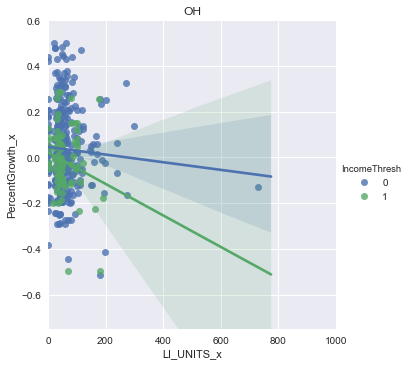

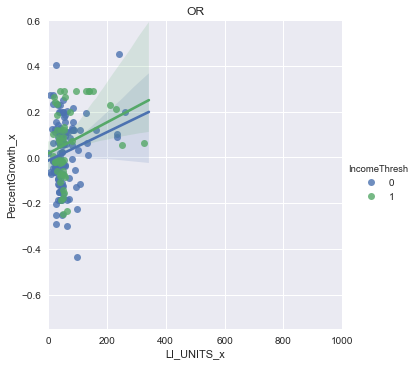

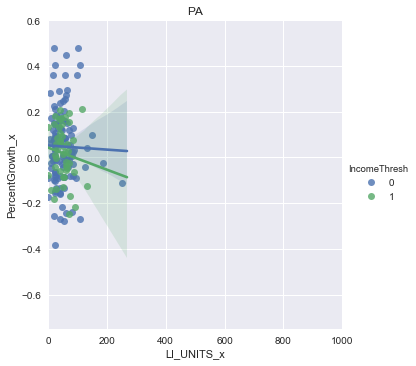

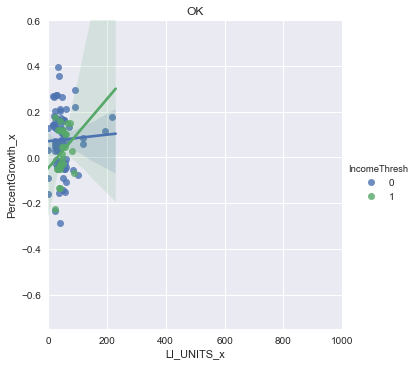

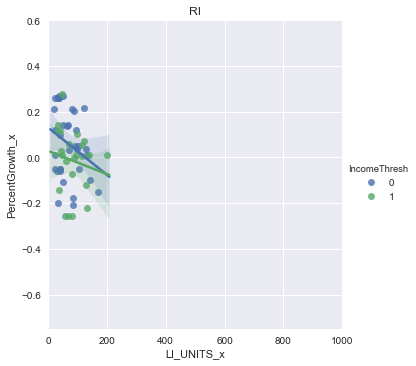

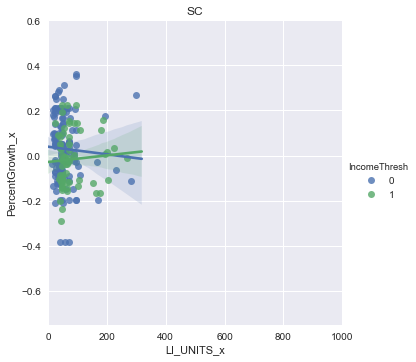

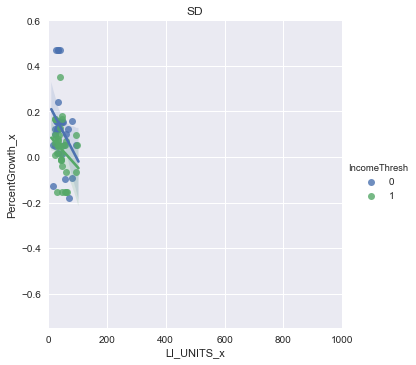

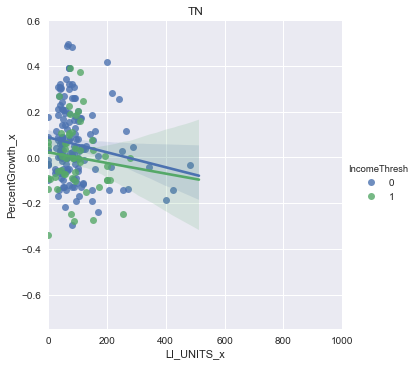

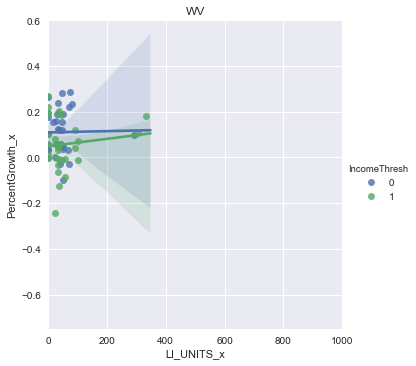

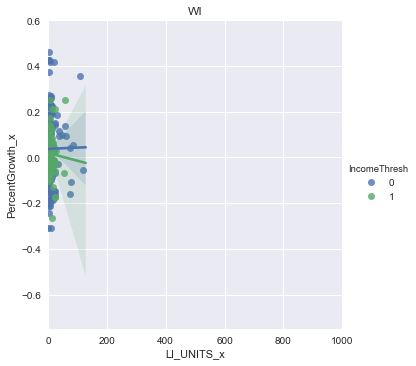

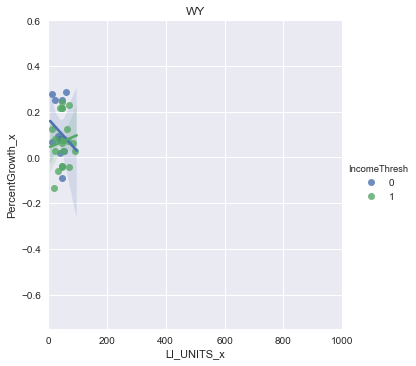

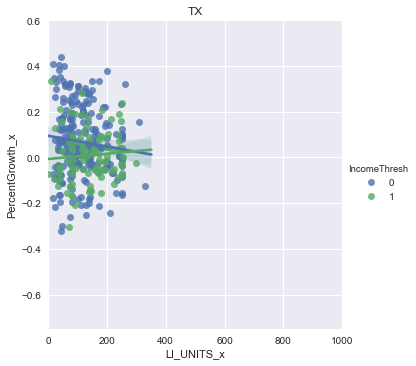

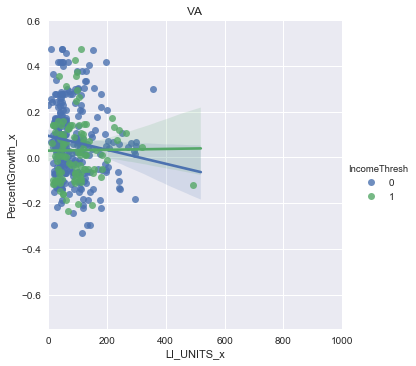

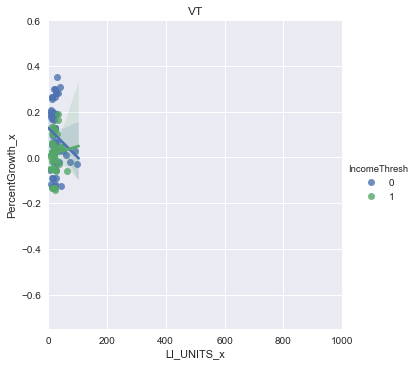

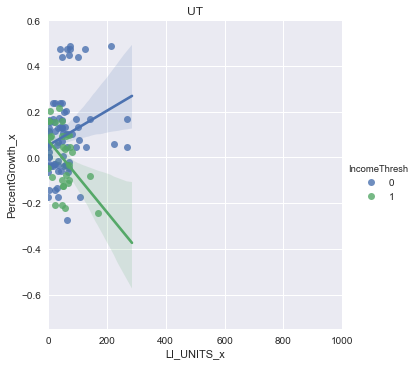

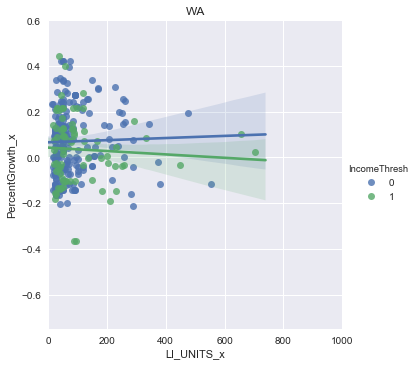

In [18]:
#create linear regression by state. start by getting a list of states from the column of Project States
statelist = df_tiny.PROJ_ST_x.unique()
print statelist
print len(statelist)

for state in statelist:
    print "~~~~~~RUNNING FOR " + str(state) + " ~~~~~~"
    df_state = df[(df.PROJ_ST_x == state)]
    lm  = sns.lmplot(x="LI_UNITS_x", y="PercentGrowth_x", order=1, data=df_state, hue='IncomeThresh')
    axes = lm.axes
    axes[0,0].set_ylim(-0.75,.6)
    axes[0,0].set_xlim(0,1000)
    sns.plt.title(state)
    lm.savefig('pictures/'+state + '.png')
    
    X = df_state[['MHI_2010_x','LI_UNITS_x','TargetPop_1','DDA_1','IncomeThresh']]

#square polynomial
#log transform the number of units

    y = df_state['MHI_2014_x']
    
    
    lm = linear_model.LinearRegression()
    lm.fit(X, y)
    print lm.get_params
    print lm.coef_
    print 'R-squared', lm.score(X,y)
    print 'MSE', metrics.mean_squared_error(y, lm.predict(X))
    #print lm.predict(np.array([100,0,0,1])) 
    
 